# Clustering Lyrical Data

Notebook Shortcuts:
1. [Introduction and Limitations](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/1_Introduction_and_Limitations.ipynb)
2. [Exploration](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/2_Exploration.ipynb)
3. [Cleaning Lyrics](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/3_Cleaning_Lyrics.ipynb)
4. [Topic Modeling](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/4_Topic_Modeling.ipynb)
5. [More Topic Modeling and Clustering](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/5_More_Topic_Modeling_and_Clustering.ipynb) (you are here)
6. [Conclusion and Wordclouds](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/6_Conclusion_and_Wordclouds.ipynb)

# 5: More Topic Modeling and Clustering

This is a continuation of the topic modeling in notebook 4. This notebook will primarily be aimed at tuning the LDA model until it has achieved its perceived best result. The last notebook discovered that LDA using 10 topics returned the highest coherence score for both the training and testing set. The initial training group was mostly meant to determine which type of model to use and not so much how to tune a particular model to its optimum parameters. Since LDA appeared to have the greatest result of the three models explored (LDA, LSI/LSA and NNMF), it now makes sense to attempt to tune its parameters to maximize its results.

In [333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pprint
%matplotlib inline

from gensim.models import LdaModel, CoherenceModel
from gensim import corpora
import pyLDAvis

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

import logging
from time import localtime, time, asctime
from datetime import timedelta

pd.options.display.max_columns = 120

In [48]:
%%capture
from tqdm import tqdm
try:
    tqdm._instances.clear()
    tqdm.pandas()
except:
    tqdm.pandas()

Set up another log file.

In [2]:
year = localtime().tm_year
month = localtime().tm_mon
day = localtime().tm_mday
hour = localtime().tm_hour
minute = localtime().tm_min
second = localtime().tm_sec
approx_time = '{}_{}_{}_{}_{}_{}'.format(month, day, year, hour, minute, second)

logfile = r'logs\topic_modeling_cont_log_' + approx_time + '.log'
logging.basicConfig(filename=logfile, level=logging.INFO, format='%(asctime)s : %(levelname)s : %(message)s')

Get the data back into its proper shape/format for modeling.

In [3]:
lemma_train = pd.read_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\lemma_base_stop_removed_clean_train.pkl')
lemma_test = pd.read_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\lemma_test.pkl')

Recreate useful functions.

In [26]:
def string_series_to_gensim_dict(series):
    docs_of_words = series.apply(lambda x: x.split()).tolist()
    dictionary = corpora.Dictionary(docs_of_words)
    return dictionary

def create_corpus(series, dictionary):
    docs_of_words = series.apply(lambda x: x.split()).tolist()
    corpus = [dictionary.doc2bow(doc) for doc in docs_of_words]
    return corpus

def run_lda_model(num_topics, corpus, dictionary):
    model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     random_state=23,
                     num_topics=num_topics,
                     passes=10,
                     offset=50,
                     iterations=100,
                     eval_every=1,
                     per_word_topics=True,
                     chunksize=5000)
    return model

def topic_df(num_topics, num_words=10):
    title_string = f'LDA with {num_topics} Topics: {num_words} Words'
    print('-'*len(title_string))
    print(title_string)    
    print('-'*len(title_string))
    topics_terms = lda_models[num_topics].show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
    topics_strings = [f'Topic_{topic+1}' for topic, _ in topics_terms]
    topic_top_words = [[word for word, _ in list_of_tups] for list_of_tups in [tups for _, tups in topics_terms]]
    topic_dict = {}
    for topics_string, topic_words in zip(topics_strings, topic_top_words):
        topic_dict[topics_string] = topic_words
    return pd.DataFrame(topic_dict)

Recreate training dictionary and corpus.

In [5]:
dictionary = string_series_to_gensim_dict(lemma_train)
corpus = create_corpus(lemma_train, dictionary)

## 5.1: Tuning Number of Topics

Rerun modeling for LDA using topics of size 5 through 15 (the perceived sweet spot).

In [6]:
lda_models = {}
for num_topics in range(5, 16):
    print(f'{asctime()}: Executing topic modeling using LDA with {num_topics} topics...', end='')
    start_time = time()
    try:
        model = run_lda_model(num_topics, corpus, dictionary)
        total_seconds = time() - start_time
        print_time = str(timedelta(seconds=round(total_seconds)))
        print(f'DONE (Time to complete: {print_time})')
        lda_models[num_topics] = model
    except:
        print(f'ERROR RUNNING MODEL @ {asctime()}')
print('ALL MODELS COMPLETE')

Wed Mar 11 01:44:32 2020: Executing topic modeling using LDA with 5 topics...DONE (Time to complete: 0:40:46)
Wed Mar 11 02:25:17 2020: Executing topic modeling using LDA with 6 topics...DONE (Time to complete: 0:41:48)
Wed Mar 11 03:07:05 2020: Executing topic modeling using LDA with 7 topics...DONE (Time to complete: 0:41:41)
Wed Mar 11 03:48:46 2020: Executing topic modeling using LDA with 8 topics...DONE (Time to complete: 0:41:29)
Wed Mar 11 04:30:15 2020: Executing topic modeling using LDA with 9 topics...DONE (Time to complete: 0:41:12)
Wed Mar 11 05:11:26 2020: Executing topic modeling using LDA with 10 topics...DONE (Time to complete: 0:42:19)
Wed Mar 11 05:53:45 2020: Executing topic modeling using LDA with 11 topics...DONE (Time to complete: 0:41:35)
Wed Mar 11 06:35:21 2020: Executing topic modeling using LDA with 12 topics...DONE (Time to complete: 0:42:28)
Wed Mar 11 07:17:49 2020: Executing topic modeling using LDA with 13 topics...DONE (Time to complete: 0:41:12)
Wed Ma

Pickle the LDA models.

In [7]:
outfile = open(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\models\lda_models.pkl', 'wb')
pickle.dump(lda_models, outfile)
outfile.close()

Get tokenized documents for train and test lyrics.

In [8]:
train_tokens = [x for x in lemma_train.str.split()]
test_tokens = [x for x in lemma_test.str.split()]

Get coherence scores for train lyrics and test lyrics for each model of varying topic lengths.

In [9]:
def get_coherence(doc_tokens):
    coherence_scores = {}
    for key in lda_models.keys():
        start_time = time()
        print(f'{asctime()}: Finding coherence score for {key}...', end='')
        try:
            coherence_model = CoherenceModel(model=lda_models[key], texts=doc_tokens, dictionary=dictionary, coherence='c_v')
            coherence_scores[key] = coherence_model.get_coherence()
            total_seconds = time() - start_time
            print_time = str(timedelta(seconds=round(total_seconds)))
            print(f'OPERATION SUCCESS (Time to complete: {print_time})')
        except:
            print(f'OPERATION FAIL @ {asctime()}')
    return coherence_scores

In [10]:
train_coherence = get_coherence(train_tokens)
test_coherence = get_coherence(test_tokens)

Wed Mar 11 09:22:04 2020: Finding coherence score for 5...OPERATION SUCCESS (Time to complete: 0:00:38)
Wed Mar 11 09:22:43 2020: Finding coherence score for 6...OPERATION SUCCESS (Time to complete: 0:00:42)
Wed Mar 11 09:23:25 2020: Finding coherence score for 7...OPERATION SUCCESS (Time to complete: 0:00:50)
Wed Mar 11 09:24:14 2020: Finding coherence score for 8...OPERATION SUCCESS (Time to complete: 0:00:56)
Wed Mar 11 09:25:10 2020: Finding coherence score for 9...OPERATION SUCCESS (Time to complete: 0:01:00)
Wed Mar 11 09:26:09 2020: Finding coherence score for 10...OPERATION SUCCESS (Time to complete: 0:01:05)
Wed Mar 11 09:27:14 2020: Finding coherence score for 11...OPERATION SUCCESS (Time to complete: 0:01:09)
Wed Mar 11 09:28:23 2020: Finding coherence score for 12...OPERATION SUCCESS (Time to complete: 0:01:14)
Wed Mar 11 09:29:37 2020: Finding coherence score for 13...OPERATION SUCCESS (Time to complete: 0:01:16)
Wed Mar 11 09:30:53 2020: Finding coherence score for 14...O

Get data ready to graph.

In [20]:
train_names = [str(name) for name in train_coherence.keys()]
train_scores = [score for score in train_coherence.values()]

test_names = [str(name) for name in test_coherence.keys()]
test_scores = [score for score in test_coherence.values()]

avg_scores = [np.mean([train_score, test_score]) for train_score, test_score in zip(train_scores, test_scores)]

Plot coherence.

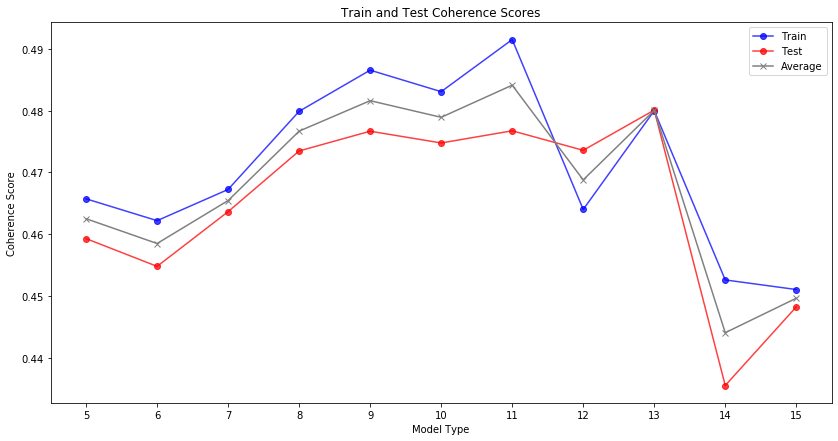

In [22]:
plt.figure(figsize=(14,7))
plt.plot(train_names, train_scores, marker='o', color='b', label='Train', alpha=.75)
plt.plot(test_names, test_scores, marker='o', color='r', label='Test', alpha=.75)
plt.plot(train_names, avg_scores, marker='x', color='gray', label='Average')
plt.xlabel('Model Type')
plt.ylabel('Coherence Score')
plt.title('Train and Test Coherence Scores')
plt.legend()
plt.show()

Generally, when choosing a number of topics using coherence as the basis for selection, finding the point where a score levels out or drops off is usually the best method. In this case it appears to be at 11 topics. The scores for the training set have topped off while the test set has been in a state of consistency since 8 topics. This can be seen pretty easily when looking at the average line in gray. Now there is another rise at 13 topics, but it falls significantly afterwards, so I think 11 is the better selection. But of course, let's give the topics and eye test to make sure it looks reasonable.

In [28]:
topic_df(11, 15)

----------------------------
LDA with 11 Topics: 15 Words
----------------------------


Topic_1 Topic_2 Topic_3 Topic_4 Topic_5  Topic_6 Topic_7    Topic_8  \
0     world    soul   night     man    baby     love    time       home   
1   tonight    life   dance   woman    girl    heart    life       road   
2     thing   death    song     boy     way      arm     way       ride   
3      mind   world    rock    town     boy     kiss     day      train   
4     lover     man   music     kid    time    touch   thing       mile   
5     sleep     war  people  friend     day     hold    mind      shake   
6    wonder   child   light    year   cause     need    word        car   
7    moment   blood    hand    head   night     life     eye      drive   
8       joy    pain    roll  people   thing      eye   cause      wheel   
9     peace   power   party    hand    talk     hand  friend      piece   
10     ring    hand    turn  mother   honey     fool    face         go   
11    dream    fear     bit     lot    care    night  change       line   
12      eye     eye   floor     day    babe     feel     end       town   
13     bell    hell    city     bed    work  feeling   place      ghost   
14  miracle     sin    blue   daddy    bout    cause    head  something   

    Topic_9 Topic_10 Topic_11  
0       day    money     body  
1       eye     shit    blood  
2     night    bitch     skin  
3     dream     fuck     bone  
4       sky      ass  breathe  
5      rain    cause    mouth  
6     light     game    brain  
7      wind   niggas    taste  
8      star      pop   breath  
9       sun     club     head  
10     time      gun    flesh  
11    heart     shot     jump  
12    water     drop     vein  
13  morning      hoe   tongue  
14     hand    check   animal

- Topic #1: thinking/dreaming positively
- Topic #2: life/death/war
- Topic #3: party
- Topic #4: family/people
- Topic #5: relationship
- Topic #6: love/physical
- Topic #7: headspace/concepts
- Topic #8: travel
- Topic #9: illumination/elements
- Topic #10: money/profane
- Topic #11: physical body

I think some of these are harder to derive than others, but they seem to cover a decent amount of what this corpus is all about.

In [33]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_models[11], corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.162821 -0.020079       1        1  21.795778
3     -0.082109 -0.157908       2        1  13.149342
8      0.145842  0.032885       3        1  12.343554
1      0.057407  0.148059       4        1  12.166539
9     -0.164153 -0.150421       5        1   8.620216
4      0.105267 -0.142699       6        1   8.415821
5      0.216561  0.075250       7        1   7.851221
2     -0.042848 -0.112288       8        1   5.445746
0      0.132746  0.118703       9        1   3.945659
7     -0.235341 -0.127718      10        1   3.231226
10    -0.296193  0.336216      11        1   3.034897, topic_info=       Term           Freq          Total Category  logprob  loglift
14     love  132661.000000  132661.000000  Default  30.0000  30.0000
61     baby   64620.000000   64620.000000  Default  29.0000  29.0000
221   world   38366.000000   38366.000000  Default  28.0000  28.0000
77    thing   46479.000000   46479.000000  Default  27.0000  27.0000
110    girl   40677.000000   40677.000000  Default  26.0000  26.0000
...     ...            ...            ...      ...      ...      ...
1813  smell     943.736084    1648.523438  Topic11  -4.8518   2.9372
576     cut     921.106506    1706.216309  Topic11  -4.8760   2.8785
1666   rush     873.311218    1497.062988  Topic11  -4.9293   2.9560
325    neck     946.213013    1884.636230  Topic11  -4.8492   2.8060
70     head    1960.291626   19328.662109  Topic11  -4.1208   1.2065

[809 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1445      4  0.997786   abyss
5287      5  0.015987   achin
5287      6  0.975197   achin
6         7  0.999171   adore
1802      1  0.087300  affair
...     ...       ...     ...
107       8  0.000862    year
107       9  0.002586    year
826       5  0.997737      yo
314      11  0.998326  zombie
870       2  0.994763    zoom

[2228 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 9, 2, 10, 5, 6, 3, 1, 8, 11])

This tool is far from perfect but it can give more insight into the relative size of topics as well as comparative distances between topics. Note: the topic numbers here do not match the topic numbers from the base model, this visualization appears to go from the highest marginal topic distribution to the smallest.

Toying with the relevance metrics above lend some more insight into more specifics of each topic, for example when looking at topic 4 above and sliding the relevance metric all the way down, it is plain to see that these songs may deal more with religion in addition to life/death, which makes sense cause religion is generally concerned with life and death, but in a more ethereal sense. Then if we switch over to topic 11, it's very concerned with the physical body and things related to it, death also being one of those things. When viewing topic 5 it definitely looks like these are going to be rap songs, looks like curse words are contained completely within this topic, also quite a bit of slang. Topic 9 also appears to contain Christmas words like sleigh and merry. Topic 7 definitely follows love. Topic 3 does indeed look to be about the elements and state of day and the like. Topic 1 is very conceptual, that may be the best way to define it. Topic 6 is very reliant on baby, babe, boy, girl, so it would make sense that this topic is probably relationship related. Topic 8 definitely looks like the dance/party/moving and grooving lyrics - which happens to happen a lot at night. Topic 2 appears to be a little more country (music) oriented, which also seems to be pretty connected to family. And finally, topic 10 is basically about transportation and anything connected to it.

## 5.2: Document Topic Distributions

Now that a topic model has been chosen, next up is to actually look at the distribution of topics in each document.

In [123]:
def text2tokens(text):
    tokens = text.split()
    return tokens

def tokens2bow(tokens):
    bow = dictionary.doc2bow(tokens)
    return bow

def bow2doctopics(bow):
    doctopics = lda_models[11].get_document_topics(bow)
    return doctopics

def series_text2doctopics(series):
    series = series.progress_apply(text2tokens)
    series = series.progress_apply(tokens2bow)
    series = series.progress_apply(bow2doctopics)
    return series

def series_doctopics2dataframe(series):
    series_list = []
    indexes = series.index
    for _, row_data in series.iteritems():
        data_dict = dict(row_data)
        for i in range(0,11):
            if i not in data_dict:
                data_dict[i] = 0
        series_list.append(pd.Series(data_dict).sort_index())
    dataframe = pd.concat(series_list, axis=1)
    dataframe.columns = indexes
    doc_topic_df = dataframe.T
    return doc_topic_df

In [52]:
train_doctopics = series_text2doctopics(lemma_train)

100%|██████████████████████████████████████████████████████████████████████████| 117020/117020 [01:54<00:00, 1021.15it/s]


The idea is that each song has a weight of topics, some topics more prevalent than others, so the goal is to find the relationships between songs using these presumed topics, maybe there are particular groups of songs that follow a similar distribution of topics.

In [114]:
train_doctopic_df = series_doctopics2dataframe(train_doctopics)

In [118]:
train_doctopic_df.columns = ['Positive_Think', 'Life_Death', 'Party', 'Family_People', 'Relationship', 'Love', 'Conceptual', 'Travel', 'Elements', 'Profane', 'Physical_Body'] 

In [122]:
train_doctopic_df.describe()

Positive_Think     Life_Death          Party  Family_People  \
count   117020.000000  117020.000000  117020.000000  117020.000000   
mean         0.040372       0.117932       0.048503       0.120339   
std          0.087170       0.198432       0.106538       0.184316   
min          0.000000       0.000000       0.000000       0.000000   
25%          0.000000       0.000000       0.000000       0.000000   
50%          0.000000       0.000000       0.000000       0.000000   
75%          0.046141       0.167927       0.050509       0.196282   
max          0.990628       0.988912       0.987714       0.982141   

        Relationship           Love     Conceptual         Travel  \
count  117020.000000  117020.000000  117020.000000  117020.000000   
mean        0.078779       0.084413       0.239820       0.030373   
std         0.156468       0.153409       0.258061       0.071372   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.170806       0.000000   
75%         0.088982       0.107909       0.411115       0.030170   
max         0.990328       0.984847       0.988912       0.960472   

            Elements        Profane  Physical_Body  
count  117020.000000  117020.000000  117020.000000  
mean        0.131719       0.057409       0.027100  
std         0.195808       0.140716       0.065536  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000  
75%         0.213019       0.024640       0.025146  
max         0.982513       0.989423       0.981425

Unsurprisingly, the topic that appears the most looks like the conceptual topic and I think that's because it's a broad and not so well defined topic that many songs use in some form or another.

In [132]:
counts = {}
for column in train_doctopic_df.columns:
    counts[column] = (train_doctopic_df[column] != 0).sum()

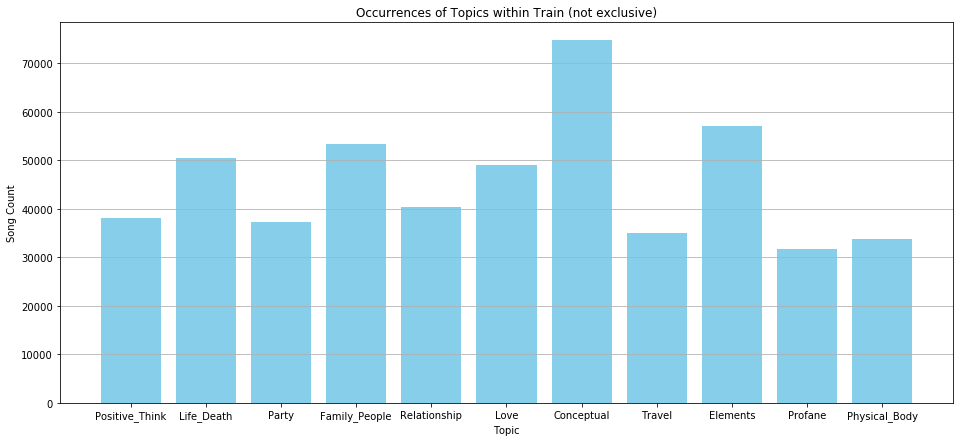

In [145]:
plt.figure(figsize=(16,7))
plt.bar(counts.keys(), counts.values(), color='skyblue')
plt.title('Occurrences of Topics within Train (not exclusive)')
plt.xlabel('Topic')
plt.ylabel('Song Count')
plt.grid(axis='y')
plt.show()

The above shows the raw appearances of each topic in a song. This doesn't mean it's the most dominant topic in the song, it just indicates that the topic is picked up by the model in the song. This could be at any strength (from the weakest to strongest).

In [147]:
non_zero_avgs = {}
for column in train_doctopic_df.columns:
    non_zero_avgs[column] = train_doctopic_df[train_doctopic_df[column] != 0][column].mean()

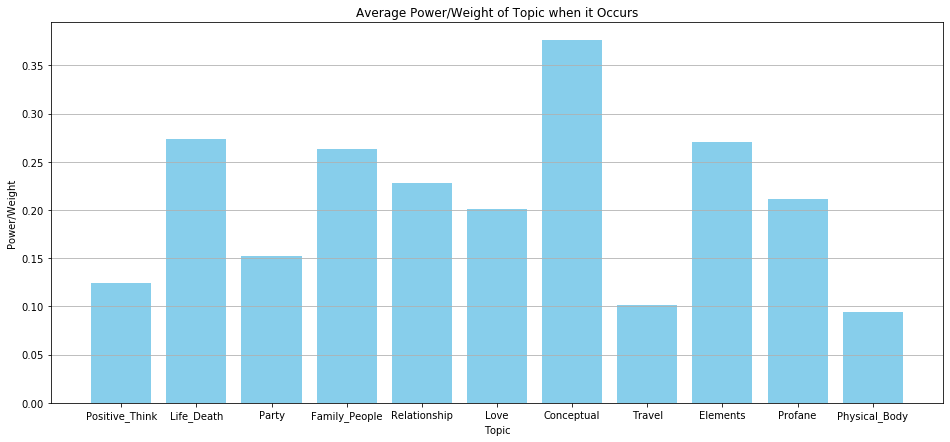

In [149]:
plt.figure(figsize=(16,7))
plt.bar(non_zero_avgs.keys(), non_zero_avgs.values(), color='skyblue')
plt.title('Average Power/Weight of Topic when it Occurs')
plt.xlabel('Topic')
plt.ylabel('Power/Weight')
plt.grid(axis='y')
plt.show()

This is better at showing the relative power of each topic when it does occur, looks like the conceptual topic, once again, has the greatest impact.

## 5.3: Clustering Topic Distributions

### 5.3.1: KMeans

KMeans will be used here to see if there are some similarities and potential clusters of songs.

In [238]:
kmeans_models = {}
for num_clusters in range(2, 21):
    print(f'{asctime()}: Executing KMeans clustering with {num_clusters} clusters...', end='')
    start_time = time()
    try:
        model = KMeans(n_clusters=num_clusters, random_state=345, n_jobs=3)
        model.fit(train_doctopic_df)
        kmeans_models[num_clusters] = model
        total_seconds = time() - start_time
        print_time = str(timedelta(seconds=round(total_seconds)))
        print(f'DONE (Time to complete: {print_time})')    
    except:
        print(f'ERROR RUNNING MODEL @ {asctime()}')
print('ALL MODELS COMPLETE')

Thu Mar 12 12:18:41 2020: Executing KMeans clustering with 2 clusters...DONE (Time to complete: 0:00:05)
Thu Mar 12 12:18:46 2020: Executing KMeans clustering with 3 clusters...DONE (Time to complete: 0:00:03)
Thu Mar 12 12:18:49 2020: Executing KMeans clustering with 4 clusters...DONE (Time to complete: 0:00:04)
Thu Mar 12 12:18:53 2020: Executing KMeans clustering with 5 clusters...DONE (Time to complete: 0:00:05)
Thu Mar 12 12:18:58 2020: Executing KMeans clustering with 6 clusters...DONE (Time to complete: 0:00:06)
Thu Mar 12 12:19:04 2020: Executing KMeans clustering with 7 clusters...DONE (Time to complete: 0:00:08)
Thu Mar 12 12:19:12 2020: Executing KMeans clustering with 8 clusters...DONE (Time to complete: 0:00:12)
Thu Mar 12 12:19:24 2020: Executing KMeans clustering with 9 clusters...DONE (Time to complete: 0:00:09)
Thu Mar 12 12:19:33 2020: Executing KMeans clustering with 10 clusters...DONE (Time to complete: 0:00:10)
Thu Mar 12 12:19:44 2020: Executing KMeans clustering 

In [239]:
kmeans_sil_scores = {}
for key in kmeans_models:
    print(f'{asctime()}: Calculating silhouette score for KMeans with {key} clusters...', end='')
    start_time = time()
    try:
        sil_score = silhouette_score(train_doctopic_df, labels=kmeans_models[key].labels_, random_state=87)
        kmeans_sil_scores[key] = sil_score
        total_seconds = time() - start_time
        print_time = str(timedelta(seconds=round(total_seconds)))
        print(f'DONE (Time to complete: {print_time})')
    except:
        print(f'ERROR RUNNING MODEL @ {asctime()}')
print('FINISHED')

Thu Mar 12 12:24:10 2020: Calculating silhouette score for KMeans with 2 clusters...DONE (Time to complete: 0:08:40)
Thu Mar 12 12:32:51 2020: Calculating silhouette score for KMeans with 3 clusters...DONE (Time to complete: 0:08:24)
Thu Mar 12 12:41:15 2020: Calculating silhouette score for KMeans with 4 clusters...DONE (Time to complete: 0:08:08)
Thu Mar 12 12:49:22 2020: Calculating silhouette score for KMeans with 5 clusters...DONE (Time to complete: 0:08:14)
Thu Mar 12 12:57:36 2020: Calculating silhouette score for KMeans with 6 clusters...DONE (Time to complete: 0:08:09)
Thu Mar 12 13:05:45 2020: Calculating silhouette score for KMeans with 7 clusters...DONE (Time to complete: 0:08:02)
Thu Mar 12 13:13:47 2020: Calculating silhouette score for KMeans with 8 clusters...DONE (Time to complete: 0:08:07)
Thu Mar 12 13:21:54 2020: Calculating silhouette score for KMeans with 9 clusters...DONE (Time to complete: 0:08:07)
Thu Mar 12 13:30:01 2020: Calculating silhouette score for KMean

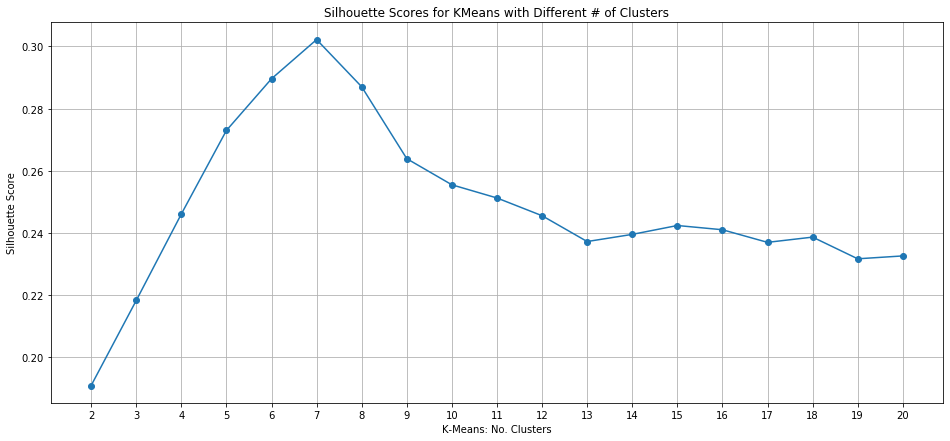

In [241]:
plt.figure(figsize=(16,7))
plt.plot(list(kmeans_sil_scores.keys()), list(kmeans_sil_scores.values()), marker='o')
plt.xticks(list(kmeans_sil_scores.keys()))
plt.title('Silhouette Scores for KMeans with Different # of Clusters')
plt.ylabel('Silhouette Score')
plt.xlabel('K-Means: No. Clusters')
plt.grid()
plt.show()

Based on the silhouette score, looks like the 7 cluster version looks to be the winner, but can DBSCAN do better?

### 5.3.2: DBSCAN

In [191]:
X = train_doctopic_df

Next, DBSCAN will be used to try and find the clusters.

To try and find a good model, the standard of min_pts = (dim * 2) will be used to estimate the min points. So in this case that will be 11 * 2 = 22.

In [215]:
eps_dbscan = {}
for eps in [.01, .03, .06, .09, .12, .15, .18, .21]:
    print(f'{asctime()}: Performing DBSCAN where eps={eps}...', end='')
    start_time = time()
    try:
        dbscan = DBSCAN(eps=eps, min_samples=22)
        dbscan.fit(X)
        eps_dbscan[eps] = dbscan
        total_seconds = time() - start_time
        print_time = str(timedelta(seconds=round(total_seconds)))
        print(f'DONE (Time to complete: {print_time})')
    except:
        print(f'ERROR RUNNING MODEL @ {asctime()}')
print('FINISHED')

Thu Mar 12 09:14:25 2020: Performing DBSCAN where eps=0.01...DONE (Time to complete: 0:01:33)
Thu Mar 12 09:15:58 2020: Performing DBSCAN where eps=0.03...DONE (Time to complete: 0:01:42)
Thu Mar 12 09:17:40 2020: Performing DBSCAN where eps=0.06...DONE (Time to complete: 0:02:07)
Thu Mar 12 09:19:47 2020: Performing DBSCAN where eps=0.09...DONE (Time to complete: 0:02:43)
Thu Mar 12 09:22:30 2020: Performing DBSCAN where eps=0.12...DONE (Time to complete: 0:03:33)
Thu Mar 12 09:26:03 2020: Performing DBSCAN where eps=0.15...DONE (Time to complete: 0:04:29)
Thu Mar 12 09:30:31 2020: Performing DBSCAN where eps=0.18...DONE (Time to complete: 0:05:15)
Thu Mar 12 09:35:47 2020: Performing DBSCAN where eps=0.21...DONE (Time to complete: 0:06:39)
FINISHED


In [216]:
dbscan_sil_scores = {}
for key in eps_dbscan:
    print(f'{asctime()}: Calculating silhouette score for DBSCAN with eps={key}...', end='')
    start_time = time()
    try:
        sil_score = silhouette_score(X, labels=eps_dbscan[key].labels_, random_state=56)
        dbscan_sil_scores[key] = sil_score
        total_seconds = time() - start_time
        print_time = str(timedelta(seconds=round(total_seconds)))
        print(f'DONE (Time to complete: {print_time})')
    except:
        print(f'ERROR RUNNING MODEL @ {asctime()}')
print('FINISHED')

Thu Mar 12 09:42:26 2020: Calculating silhouette score for DBSCAN with eps=0.01...DONE (Time to complete: 0:09:10)
Thu Mar 12 09:51:36 2020: Calculating silhouette score for DBSCAN with eps=0.03...DONE (Time to complete: 0:08:56)
Thu Mar 12 10:00:32 2020: Calculating silhouette score for DBSCAN with eps=0.06...DONE (Time to complete: 0:08:31)
Thu Mar 12 10:09:04 2020: Calculating silhouette score for DBSCAN with eps=0.09...DONE (Time to complete: 0:08:27)
Thu Mar 12 10:17:31 2020: Calculating silhouette score for DBSCAN with eps=0.12...DONE (Time to complete: 0:08:54)
Thu Mar 12 10:26:25 2020: Calculating silhouette score for DBSCAN with eps=0.15...DONE (Time to complete: 0:09:08)
Thu Mar 12 10:35:33 2020: Calculating silhouette score for DBSCAN with eps=0.18...DONE (Time to complete: 0:09:16)
Thu Mar 12 10:44:49 2020: Calculating silhouette score for DBSCAN with eps=0.21...DONE (Time to complete: 0:09:17)
FINISHED


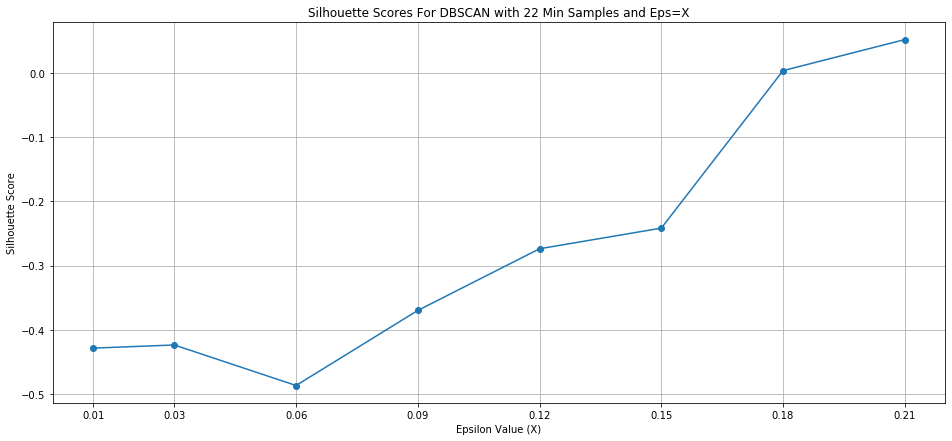

In [249]:
plt.figure(figsize=(16,7))
plt.plot(list(dbscan_sil_scores.keys()), list(dbscan_sil_scores.values()), marker='o')
plt.title('Silhouette Scores For DBSCAN with 22 Min Samples and Eps=X')
plt.ylabel('Silhouette Score')
plt.xlabel('Epsilon Value (X)')
plt.xticks(ticks=[.01, .03, .06, .09, .12, .15, .18, .21], labels=[.01, .03, .06, .09, .12, .15, .18, .21])
plt.grid()
plt.show()

So as useful as DBSCAN can be for finding clusters without knowing how many clusters there are initially, in this case since the data is so sparse and so "close" together, it's proving difficult to tune. Generally, I would run DBSCAN over and over again using minute differences in the epsilon and min_pts/min_samples parameters then compare their silhouette scores and filter the bad models out to only inspect the ones that looked pretty good. In this case though, finding the silhouette scores for so many models would be extremely time consuming and computationally expensive, so sticking with the KMeans model is likely the best bet in this particular case.

## 5.4: Visualizing the KMeans Clusters

It definitely appears that 7 was the magic number when it came to KMeans using this data, so it would be useful to try and get a visual representation of that data.

In [263]:
clusters = kmeans_models[7].labels_ + 1

Try out TSNE dimensionality reduction for a 2D representation of the data.

In [250]:
tsne_X = {}
for perplexity in [10, 25, 50, 75, 100, 150, 200]:
    print(f'{asctime()}: Reducing to 2 dimensions using TSNE with perplexity={perplexity}...')
    start_time = time()
    try:
        tsne = TSNE(perplexity=perplexity, init='pca', random_state=5344, n_jobs=-1)
        tsne_X[perplexity] = tsne.fit_transform(X)
        total_seconds = time() - start_time
        print_time = str(timedelta(seconds=round(total_seconds)))
        print(f'DONE (Time to complete: {print_time})')
    except:
        print(f'ERROR RUNNING @ {asctime()}')
print('FINISHED')

Thu Mar 12 19:10:56 2020: Reducing to 2 dimensions using TSNE with perplexity=10...
DONE (Time to complete: 0:32:29)
Thu Mar 12 19:43:25 2020: Reducing to 2 dimensions using TSNE with perplexity=25...
DONE (Time to complete: 0:37:10)
Thu Mar 12 20:20:36 2020: Reducing to 2 dimensions using TSNE with perplexity=50...
DONE (Time to complete: 0:42:50)
Thu Mar 12 21:03:26 2020: Reducing to 2 dimensions using TSNE with perplexity=75...
DONE (Time to complete: 0:48:48)
Thu Mar 12 21:52:14 2020: Reducing to 2 dimensions using TSNE with perplexity=100...
DONE (Time to complete: 0:54:41)
Thu Mar 12 22:46:55 2020: Reducing to 2 dimensions using TSNE with perplexity=150...
DONE (Time to complete: 1:05:47)
Thu Mar 12 23:52:42 2020: Reducing to 2 dimensions using TSNE with perplexity=200...
DONE (Time to complete: 1:15:46)
FINISHED


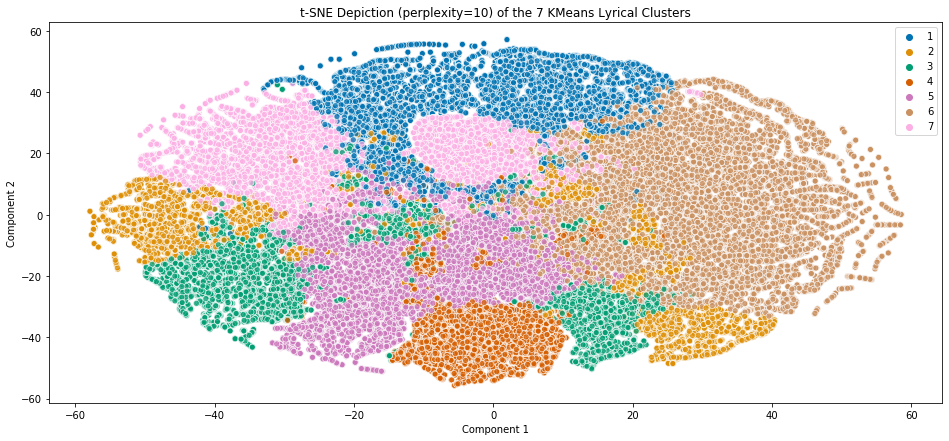

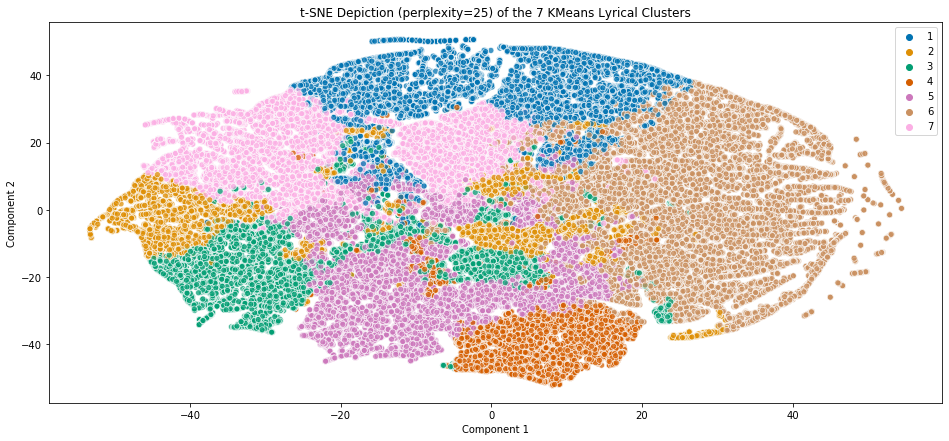

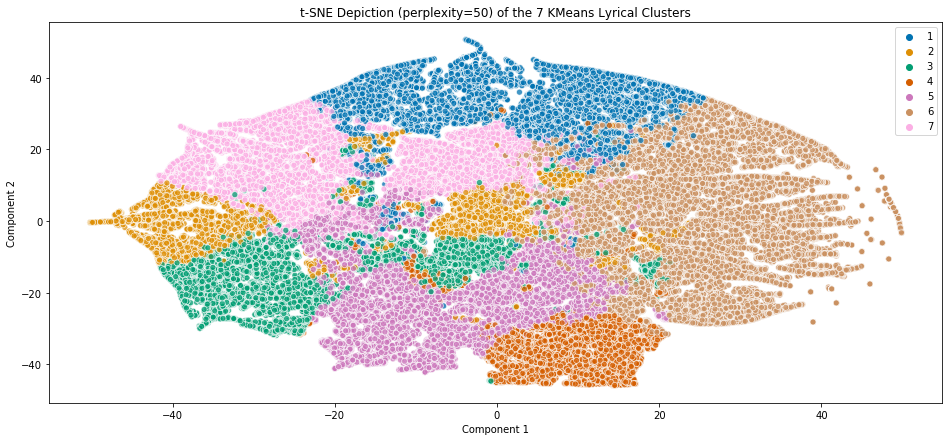

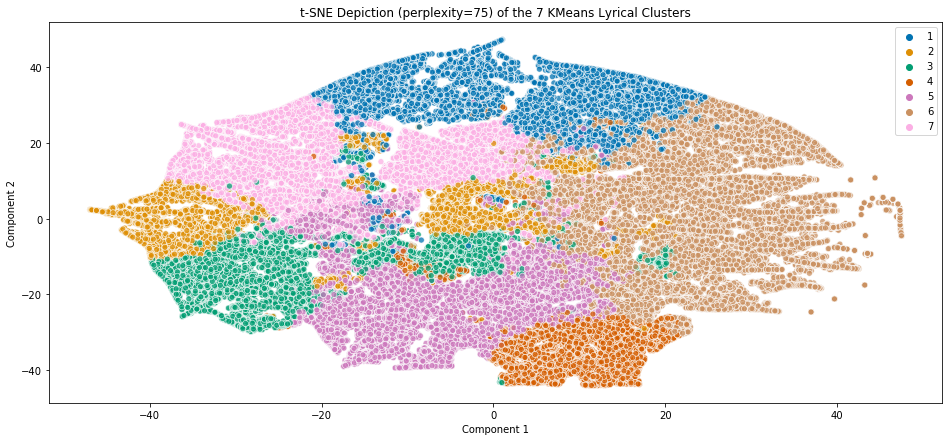

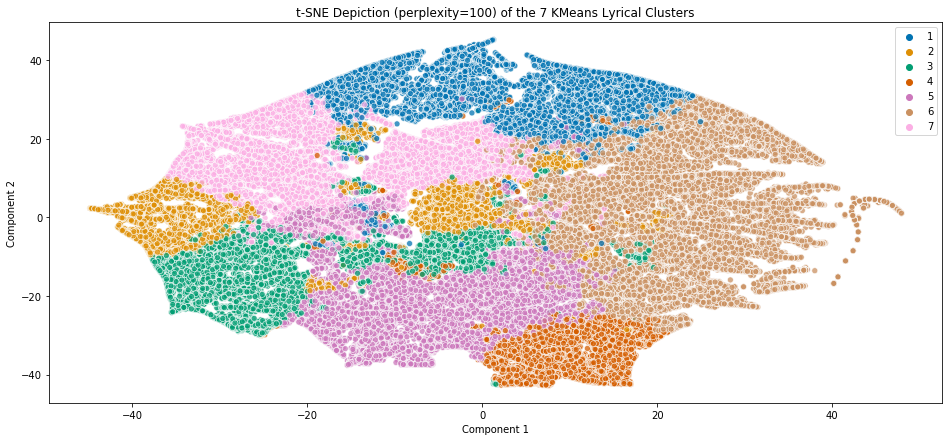

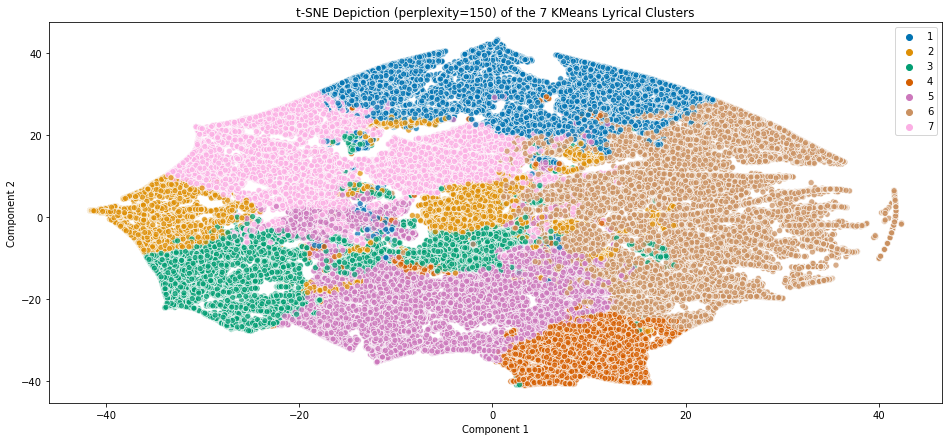

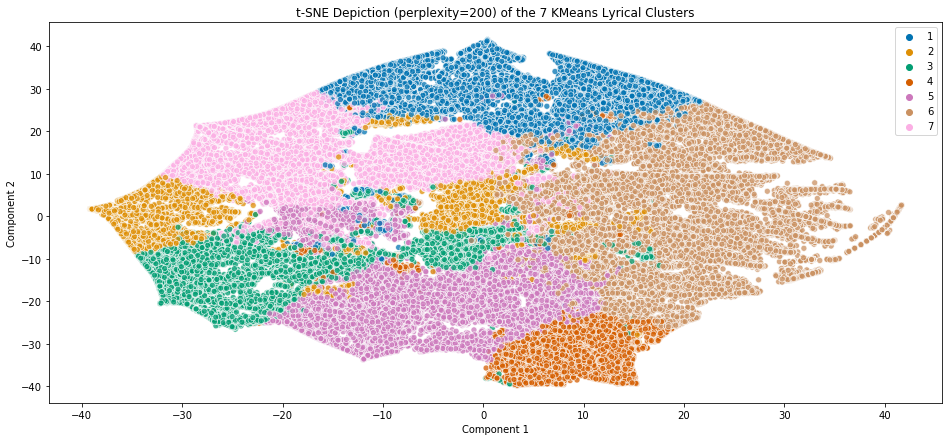

In [274]:
for key in tsne_X:
    x = tsne_X[key][:, 0]
    y = tsne_X[key][:, 1]
    hue = clusters
    plt.figure(figsize=(16,7))
    sns.scatterplot(x, y, hue, palette='colorblind', legend='full', alpha=.75)
    plt.title(f't-SNE Depiction (perplexity={key}) of the 7 KMeans Lyrical Clusters')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

At the higher perplexity values it does appear that, for the most part, the clusters are pretty close together and relatively well connected. The main downside of this is the extremely long compute time. It could be of use to go higher in perplexity to see if a more appropriate visual could be found since the amount of data is pretty large, but the perplexity of 200 appears to be a relatively good visual.

## 5.5: What's in a cluster?

Plenty of time has gone into determining an appropriate amount of topics, clustering those topics to create more specific clusters and using silhouette scores to determine the appropriate amount of clusters. Then finally using dimensionality reduction to see if a 2D visual representation could be created with those those 7 clusters. But, what is really in a cluster? What does it mean to be a part of cluster 5, or 3, or any of them? Makes sense to find out and see.

Before digging into the songs specifically, it makes sense to look into the topics, since that is ultimately what the clustering is concerned with, this should give some insight into what the songs are about without having to sift through the lyrics.

In [267]:
X['Cluster'] = clusters

In [272]:
X.groupby('Cluster').agg(['mean'])

Positive_Think Life_Death     Party Family_People Relationship  \
                  mean       mean      mean          mean         mean   
Cluster                                                                  
1             0.027761   0.540977  0.027337      0.045065     0.013409   
2             0.056542   0.039809  0.044974      0.033827     0.067936   
3             0.063050   0.027005  0.098872      0.057608     0.414142   
4             0.019894   0.044180  0.051230      0.129812     0.051353   
5             0.034687   0.056201  0.060562      0.453353     0.044867   
6             0.036615   0.058156  0.035142      0.044980     0.030022   
7             0.046942   0.069283  0.041570      0.054133     0.031428   

             Love Conceptual    Travel  Elements   Profane Physical_Body  
             mean       mean      mean      mean      mean          mean  
Cluster                                                                   
1        0.029699   0.121459  0.019911  0.084600  0.021991      0.044829  
2        0.466531   0.139183  0.022036  0.070047  0.014632      0.018773  
3        0.083098   0.087140  0.038625  0.049637  0.037507      0.022422  
4        0.023618   0.085859  0.025453  0.030514  0.497734      0.026392  
5        0.034816   0.110596  0.042412  0.069748  0.043221      0.029156  
6        0.047772   0.589498  0.026557  0.059981  0.020933      0.023585  
7        0.055270   0.101599  0.034184  0.502321  0.014218      0.024401

Looking at the average values, it's relatively easy to see how the clustering generally separated songs by their topics. It also appears that certain topics don't actually have a lot of weight and are more evenly distributed throughout songs. The cluster rundown looks like this:
- Cluster #1: Concerned with life and death (the topic)
- Cluster #2: Love songs with a hint of conceptual in there, isn't especially weak in any topics except profanity and physical body
- Cluster #3: Relationship songs (specifically baby/babe), these occur so much that they basically have their own cluster (in the future babe/baby may need to be stop words?)
- Cluster #4: Almost definitely profane songs, appears that family/people also occurs very often in this cluster (also one of the lowest conceptual scores)
- Cluster #5: Lyrics about people and potentially family
- Cluster #6: Conceptual tracks, probably the hardest topic to nail down as to what it is exactly
- Cluster #7: Element concerned music, the weakest case of profanity occurs here

(Note: Since the "conceptual" topic was so broad and relatively all encompassing, it appears to a relatively high degree in pretty much all the clusters, with the lowest average being 8.6% - cluster #4.)

In [273]:
X.groupby('Cluster').agg(['median'])

Positive_Think Life_Death  Party Family_People Relationship      Love  \
                median     median median        median       median    median   
Cluster                                                                         
1                  0.0   0.515885    0.0      0.000000     0.000000  0.000000   
2                  0.0   0.000000    0.0      0.000000     0.000000  0.443430   
3                  0.0   0.000000    0.0      0.000000     0.404552  0.035458   
4                  0.0   0.000000    0.0      0.116171     0.000000  0.000000   
5                  0.0   0.000000    0.0      0.432631     0.000000  0.000000   
6                  0.0   0.000000    0.0      0.000000     0.000000  0.000000   
7                  0.0   0.000000    0.0      0.000000     0.000000  0.000000   

        Conceptual Travel  Elements   Profane Physical_Body  
            median median    median    median        median  
Cluster                                                      
1         0.065658    0.0  0.000000  0.000000           0.0  
2         0.101684    0.0  0.000000  0.000000           0.0  
3         0.000000    0.0  0.000000  0.000000           0.0  
4         0.025504    0.0  0.000000  0.475977           0.0  
5         0.052750    0.0  0.000000  0.000000           0.0  
6         0.567147    0.0  0.000000  0.000000           0.0  
7         0.000000    0.0  0.481348  0.000000           0.0

Looking at the median values makes the clusters and their main topics even more apparent. And also goes to show that the "conceptual" topic is pretty ubiquitous.

In [289]:
def set_cluster_name(cluster_no):
    if cluster_no == 1:
        return '1 Life/Death'
    elif cluster_no == 2:
        return '2 Love'
    elif cluster_no == 3:
        return '3 Relationship/Baby'
    elif cluster_no == 4:
        return '4 Profane'
    elif cluster_no == 5:
        return '5 People/Family'
    elif cluster_no == 6:
        return '6 Conceptual'
    elif cluster_no == 7:
        return '7 Elements'
    else:
        return None

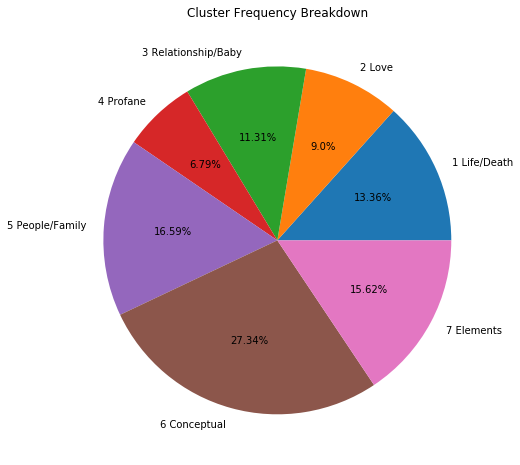

In [292]:
cluster_counts = X.Cluster.apply(set_cluster_name).value_counts().sort_index()
plt.figure(figsize=(8,8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct=lambda pct: f'{round(pct, 2)}%')
plt.title('Cluster Frequency Breakdown')
plt.show()

Unsurprisingly, the "conceptual" cluster has the greatest number of tracks. This is due to the broadness of this topic. The others are more closely distributed, perhaps with the exception of topic 4, which is the profane topic, it has a relatively low number of tracks.

## 5.6: Lyric Inspection

In [310]:
train_orig_lyrics = pd.read_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\train.pkl')
train_token_series = lemma_train.str.split()
train_clusters = X.Cluster
train_clusters_names = X.Cluster.apply(set_cluster_name)

In [311]:
train_breakdown = pd.concat([train_orig_lyrics, train_token_series, train_clusters, train_clusters_names], axis=1)
train_breakdown.columns = ['lyrics', 'keywords', 'cluster', 'cluster_name']

Create a function to inspect a song in a particular cluster.

In [334]:
pp = pprint.PrettyPrinter(width=100, compact=True)

In [344]:
def view_lyrics_by_cluster(cluster, index='random'):
    cluster_df = train_breakdown[train_breakdown.cluster == cluster]
    random_index = np.random.randint(cluster_df.shape[0])
    song_info = cluster_df.iloc[random_index]
    cluster_name_string = f'Cluster: {song_info.cluster_name}'
    print(cluster_name_string)
    print('-'*len(cluster_name_string))
    print('Keywords:')
    print('---------')
    pp.pprint(list(set(song_info.keywords)))
    print('Original Lyrics:')
    print('----------------')
    print(song_info.lyrics)

In [345]:
view_lyrics_by_cluster(1)

Cluster: 1 Life/Death
---------------------
Keywords:
---------
['sea', 'cell', 'lover', 'mountain', 'touch', 'sunrise', 'life', 'saw', 'signal', 'priest', 'hell',
 'beast', 'knife', 'smell']
Original Lyrics:
----------------
I saw the sunrise deep in hell
I saw heaven in the cell
I saw the touch, i saw the smell, well, well
I saw the neverending sea
I saw the mountains of liberty
I didn't see you and i did not see me
But i'm still looking for someone
Someone that's larger than life
Something that's sharp
Sharp as the knife
I saw the sunrise deep in hell
And it grows and it grows
First signals of love
I say well, i say well
I saw the sunrise deep in hell
I saw the wild, wild beasts
I saw them run away or run at least
I saw the lovers and i saw the priest
But i'm still looking for someone
Someone that's larger than life
Something that's sharp
Sharp as the knife
I saw the sunrise deep in hell
And it grows and it grows
First signals of love
I say well, i say well
I saw the sunrise deep in

In [346]:
view_lyrics_by_cluster(2)

Cluster: 2 Love
---------------
Keywords:
---------
['sand', 'highway', 's', 'street', 'honie', 'place', 'home', 'girl', 'cruise', 'love', 'run',
 'fall', 'band']
Original Lyrics:
----------------
I wanna go to the beach, dig our toes in the sand,
Wanna roll through the streets like they know who i am
Oh oh, i think i know where i can
I wanna show you everything you can eat in Japan, I wanna be on MTV and get to chill with the bands, and oh oh, i think i know where we can
Theres a place that everybody knows, and everybody wants to go
I wanna call it my own
You can go, across the whole globe,
there's no other place youll find
that's quite as nice
It's home
It's warm when it's cold
the girls are so beautiful
youll fall in love
youll fall in love
You might run into celebrities in the street,
catch a hollywood party be on TMZ
oh oh oh oh oh oh it'd be so neat
Let's cruise down Highway 1
and bump that new Chris Brown song
we'll go to the boardwalk and meet some honies oh
theyll love me so
T

In [347]:
view_lyrics_by_cluster(3)

Cluster: 3 Relationship/Baby
----------------------------
Keywords:
---------
['dime', 'penny', 'wish', 'arm', 'shit', 'place', 'pinch', 'girl', 'time', 'smokin', 'cigarette',
 'think', 'night', 'thing', 'kid', 'fight', 'sleep']
Original Lyrics:
----------------
holy smokes, howd i get myself into this again?
now im stuck in the same damn place that i have always been
smokin all my cigarettes and wasting all my time
trying to pinch my pennies just so i can save a dime
so where you been? ill never do the stupid shit we did back then
tried to pick up ugly girls, just to make it ______*
i cant think that wherever i go that you wish i was dead
id give up my left arm if i could sleep at night
i cant remember the last time that i really had a good fight
i figured wed get married, and maybe have some kids
it only makes me sad thinking of all the things we never did
so where you been? ill never do the stupid shit we did back then
tried to pick up ugly girls, just to make it ______*
i cant thin

In [348]:
view_lyrics_by_cluster(4)

Cluster: 4 Profane
------------------
Keywords:
---------
['rock', 'metal', 'rule', 'tell', 'way', 'point', 'friend', 'hair', 'music', 'rocker', 'root',
 'moron', 'cut', 'punk', 'thing', 'care', 'boy', 'band']
Original Lyrics:
----------------
I grew up on heavy metal!
You can't listen to heavy metal!
All my friends liked heavy metal!
All your friends were morons!
Please don't make me cut my hair!
All the cool kidz cut their hair!
But now there's shitty music everywhere!
You're not supposed to care because it's
Punk rock! Punk rock!
Punk rock! Punk rock!
Punk rock! Punk rock!
Punk rock! Punk rock!
It's hard to tell what music's cool
Whatever sells the biggest rules!
I still find Krokus kinda cool!
Damn your metal roots, boy!
But none of these bands even know how to play!
We'll take it over Yngwie any day!
Okay, good point, but what's it called?!?
It's the latest thing, we'll call it
Punk rock! Punk rock!
Punk rock! Punk rock!
Punk rock! Punk rock!
Punk rock! Punk rock!
I know that I sh

In [350]:
view_lyrics_by_cluster(5)

Cluster: 5 People/Family
------------------------
Keywords:
---------
['room', 'break', 'leg', 'tax', 'face', 'dad', 'mommy', 'heart', 'ass', 'matter', 'friend', 'crime',
 'home', 'splitting', 'scab', 'time', 'boy', 'glass', 'yr', 'year', 'lock', 'wish', 'slap', 'rip',
 'birthday', 'hair', 'ear', 'care', 'man']
Original Lyrics:
----------------
. . . . . (yawn)
Make me miss amerika
rip it when we're 6 yeah
lock her in her room now
tell me it's my birthday-
i don't care.
rub her face in glass Dad
try to kick some ass Dad
tell me who's insane man
throw up exrery other day-
i don't care.
cross my legs and hold it in
say you wish you had no ears
funny how she don't exist
mommy chained her up instead-
i don't care
fill me with yr lies boy,
don't matter wasn't real
she don't wanna be my friend
but i can't stand her anyways
i can't go home again
but i'm still a good tax break
cut us off at the hearts
scabs grow thicker by the years-
i don't care.
splitting hairs and doing time
slap me till i 

In [351]:
view_lyrics_by_cluster(6)

Cluster: 6 Conceptual
---------------------
Keywords:
---------
['shake', 'craving', 'crush', 'body', 'want', 'fun', 'soul', 'heart', 'edge', 'razor', 'baby',
 'time', 'shot', 'man', 'thing', 'kindness', 'walk', 'damage', 'bullet', 'babe', 'junkie', 'dream',
 'love', 'play', 'mistake', 'watch', 'gun']
Original Lyrics:
----------------
What a dream come trueI got the biggest crush on you
My whole body shakes
I know I'm gonna break
But God I'm craving for more
The only thing I really feel is the regret of my heart
Killing you with kindness
Like a junkie pushing all his shots
I'll take a bullet in for you
Or whatever you want me to
But don't you mistake it for love
I'll walk the razors just for you
To show you a thing or two
But don't you mistake it for love
When you come in view
I'm keeping cool but man I'm so damn hot for you
I thought it would be fun
But then again I think it's turnin' upside down, down, down
Many times I realize all the damage that is to be done
If you want to see ove

In [352]:
view_lyrics_by_cluster(7)

Cluster: 7 Elements
-------------------
Keywords:
---------
['light', 'stop', 'city', 'sign', 'day', 'home', 'firework', 'night', 'memory', 'way', 'window',
 'footstep', 'thing', 'overtime', 'eye', 'road', 'goodbye', 'world', 'place', 'faith', 'life',
 'father']
Original Lyrics:
----------------
One stop light, shines into my window every night
That old stop sign, faded like a memory overtime
[Chorus]
Broken roads, won't stand in my way
Take me home, to where I found my faith
Where we walk in the footsteps in the shadows of our fathers
The city lights are way too bright
So take me home, right back home to
Savannah, Savannah, Savannah, home to
Savannah, Savannah, Savannah
Thought I had it all
But I found there's just some things you can't outgrow
The world may have changed
But the memories we made stay the same
(And they calling out my name)
[Chorus]
The place where we first met on that day won't forget
The day we said goodbye, I left you for a better life
The place where I screwed up, 

After further inspection it's plain to see that this is not a perfect method. It's likely that the clusters have not been accurately named. There does seem to be similarity between songs within clusters, but limiting the keywords to inspect to just nouns may be oversimplifying the lyrics and leading to clusters that are harder to inspect (since the original lyrics contain many more words). With that said, the results do seem to have a use, and in general the songs within clusters are generally of a certain type.

## 5.7: Evaluating the Model

In order to see if the model "works", it will be used on the holdout set. Now the evaluation step is very subjective with this kind of data. The real question is, will there be any use for this particular model outside of the training set? Also, the exact steps from start to finish need to be clearly defined. And the models used (both topic and clustering) need to work with outside data. There is quite a lot to unpack here, the broad steps are essentially as follows:
1. Convert the holdout set's lyrics to a list of noun-lemma keywords (already done)
2. Use existing LDA topic model on those keywords to get topic distributions for each song (have a function for that)
3. Use existing K-means clustering model to cluster each song into its proper cluster (have to predict this)

In [365]:
holdout_clean = pd.read_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\lemma_holdout.pkl')

In [394]:
holdout_doctopics = series_text2doctopics(holdout_clean)

100%|█████████████████████████████████████████████████████████████████████████████| 36569/36569 [00:43<00:00, 843.40it/s]


In [396]:
holdout_doctopics_df = series_doctopics2dataframe(holdout_doctopics)

In [398]:
holdout_doctopics_df.columns = ['Positive_Think', 'Life_Death', 'Party', 'Family_People', 'Relationship', 'Love', 'Conceptual', 'Travel', 'Elements', 'Profane', 'Physical_Body'] 

In [409]:
holdout_clusters = kmeans_models[7].predict(holdout_doctopics_df) + 1

In [410]:
holdout_X = pd.Series(holdout_clusters).apply(set_cluster_name)

In [415]:
perplexity = 200
tsne_holdout = {}
print(f'{asctime()}: Reducing to 2 dimensions using TSNE with perplexity={perplexity}...', end='')
start_time = time()
try:
    tsne = TSNE(perplexity=perplexity, init='pca', random_state=5344, n_jobs=-1)
    tsne_holdout[perplexity] = tsne.fit_transform(holdout_doctopics_df)
    total_seconds = time() - start_time
    print_time = str(timedelta(seconds=round(total_seconds)))
    print(f'DONE (Time to complete: {print_time})')
except:
    print(f'ERROR RUNNING @ {asctime()}')
print('FINISHED')

Fri Mar 13 14:19:35 2020: Reducing to 2 dimensions using TSNE with perplexity=200...DONE (Time to complete: 0:19:55)
FINISHED


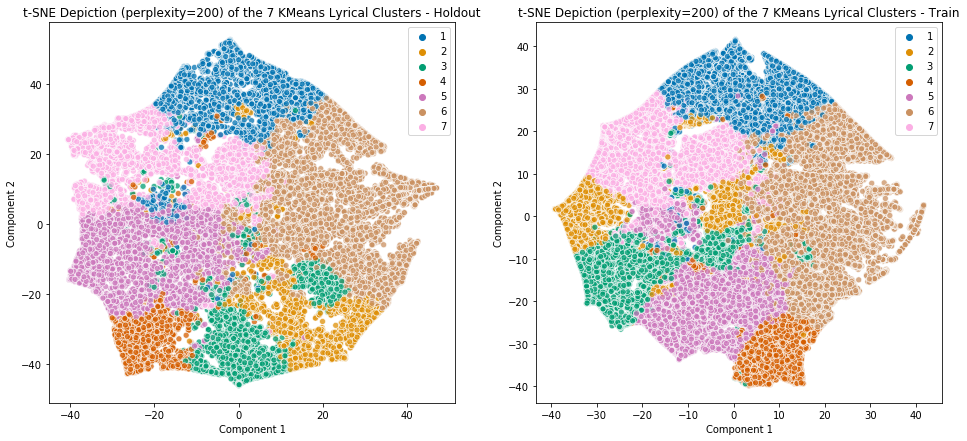

In [416]:
x1 = tsne_holdout[200][:, 0]
y1 = tsne_holdout[200][:, 1]
hue1 = holdout_clusters
x2 = tsne_X[200][:, 0]
y2 = tsne_X[200][:, 1]
hue2 = clusters
plt.figure(figsize=(16,7))
plt.subplot(121)
sns.scatterplot(x1, y1, hue1, palette='colorblind', legend='full', alpha=.75)
plt.title(f't-SNE Depiction (perplexity=200) of the 7 KMeans Lyrical Clusters - Holdout')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.subplot(122)
sns.scatterplot(x2, y2, hue2, palette='colorblind', legend='full', alpha=.75)
plt.title(f't-SNE Depiction (perplexity=200) of the 7 KMeans Lyrical Clusters - Train')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

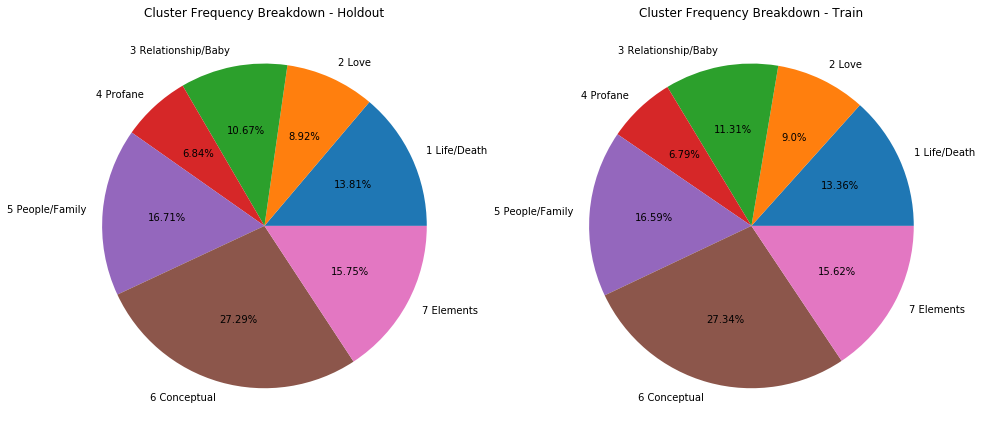

In [411]:
holdout_cluster_counts = holdout_X.value_counts().sort_index()
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.pie(holdout_cluster_counts, labels=holdout_cluster_counts.index, autopct=lambda pct: f'{round(pct, 2)}%')
plt.title('Cluster Frequency Breakdown - Holdout')
plt.subplot(122)
plt.pie(cluster_counts, labels=cluster_counts.index, autopct=lambda pct: f'{round(pct, 2)}%')
plt.title('Cluster Frequency Breakdown - Train')
plt.show()

In [413]:
holdout_sil_score = silhouette_score(holdout_doctopics_df, holdout_clusters, random_state=87)

In [414]:
holdout_sil_score

0.30062322283636744

It looks like the breakdown of clusters is very consistent, showing that this clustering technique may be useful on lyrics outside of the initial corpus. This also adds confidence to the topic modeling technique.

## 5.8: Deliverables

In [429]:
train_breakdown.cluster.to_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\train_clusters.pkl')
train_breakdown.cluster_name.to_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\train_cluster_names.pkl')

In [423]:
holdout_clusters = pd.Series(holdout_clusters, index=holdout_clean.index)
holdout_clusters.name = 'cluster'

In [425]:
holdout_clusters.to_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\holdout_clusters.pkl')

In [431]:
holdout_X.index = holdout_clean.index

In [434]:
holdout_X.to_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\holdout_cluster_names.pkl')

## Shortcuts

Notebook Shortcuts:
1. [Introduction and Limitations](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/1_Introduction_and_Limitations.ipynb)
2. [Exploration](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/2_Exploration.ipynb)
3. [Cleaning Lyrics](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/3_Cleaning_Lyrics.ipynb)
4. [Topic Modeling](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/4_Topic_Modeling.ipynb)
5. [More Topic Modeling and Clustering](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/5_More_Topic_Modeling_and_Clustering.ipynb) (you are here)
6. [Conclusion and Wordclouds](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/6_Conclusion_and_Wordclouds.ipynb)